In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from pyspec import spectrum as spec
from pathlib import Path
from glob import glob

%matplotlib inline
plt.rcParams["font.size"] = 14

In [28]:
data_path = Path("/home/gkara/Documents/for-tide_paper/")

grid = ['gridT', 'gridU', 'gridV', 'CURL']

fsummer = {}
fwinter = {}

for g in grid:
    
    fton = 'ref/'
    ftoff = 'exp1/'
    
    if g =='CURL': fton = 'CURL_' + fton; ftoff = 'CURL_' + ftoff
        
    data_summer = "*1h_" + g + "_20110[7-9]*"
    data_winter = "*1h_" + g + "_20120[1-3]*"
        
    fsummer[g] = (list(sorted(data_path.glob(fton + data_summer))), \
                list(sorted(data_path.glob(ftoff + data_summer))))
    fwinter[g] = (list(sorted(data_path.glob(fton + data_winter))), \
                list(sorted(data_path.glob(ftoff + data_winter))))

In [ ]:
# open TON data
#summer
curl_summer = xr.open_mfdataset(fsummer['CURL'][0]); curl_summer = curl_summer.fillna(0)
ds_summer = xr.merge([xr.open_mfdataset(fsummer['gridT'][0], combine='by_coords'), \
                      xr.open_mfdataset(fsummer['gridU'][0], combine='by_coords'), \
                      xr.open_mfdataset(fsummer['gridV'][0], combine='by_coords')], compat='override')
#winter
curl_winter = xr.open_mfdataset(fwinter['CURL'][0]); curl_winter = curl_winter.fillna(0)
ds_winter = xr.merge([xr.open_mfdataset(fwinter['gridT'][0], combine='by_coords'), \
                      xr.open_mfdataset(fwinter['gridU'][0], combine='by_coords'), \
                      xr.open_mfdataset(fwinter['gridV'][0], combine='by_coords')], compat='override')

# open TOFF data
#summer
curl_summer_ = xr.open_mfdataset(fsummer['CURL'][1]); curl_summer_ = curl_summer_.fillna(0)
ds_summer_ = xr.merge([xr.open_mfdataset(fsummer['gridT'][1], combine='by_coords'), \
                      xr.open_mfdataset(fsummer['gridU'][1], combine='by_coords'), \
                      xr.open_mfdataset(fsummer['gridV'][1], combine='by_coords')], compat='override')
#winter
curl_winter_ = xr.open_mfdataset(fwinter['CURL'][1]); curl_winter_ = curl_winter_.fillna(0)
ds_winter_ = xr.merge([xr.open_mfdataset(fwinter['gridT'][1], combine='by_coords'), \
                      xr.open_mfdataset(fwinter['gridU'][1], combine='by_coords'), \
                      xr.open_mfdataset(fwinter['gridV'][1], combine='by_coords')], compat='override')

In [42]:
def ssh_spectra(data, dx=3.0, dy=3.0):
    '''TODO'''
    
    t = data.shape[0]
    _spec = [spec.TWODimensional_spec(data[t,:,:].T.copy(),d1=dx,d2=dx).ispec for t in range(t)]
    
    ki = spec.TWODimensional_spec(data[0,:,:].T.copy(),d1=dx,d2=dx).ki
    ispec = np.asarray(_spec)
    
    return ki, np.array(ispec).mean(axis=0)

def KE_spectra(dataU, dataV, dx=3.0, dy=3.0):
    '''TODO'''
        
    t = dataU.shape[0]
    _specU = [spec.TWODimensional_spec(dataU[t,:,:].T.copy(),d1=dx,d2=dx).ispec for t in range(t)]
    _specV = [spec.TWODimensional_spec(dataV[t,:,:].T.copy(),d1=dx,d2=dx).ispec for t in range(t)]
    _iE = [0.5*(iu+iv) for iu,iv in zip(_specU, _specV)]
    
    ki = spec.TWODimensional_spec(dataU[0,:,:].T.copy(),d1=dx,d2=dx).ki
    ispec = np.asarray(_iE)
    
    return ki, np.array(ispec).mean(axis=0)

# compute SSH spectra
k, sd = ssh_spectra(ds_summer.sossheig[:,170:310,50:190].values)
k_, sd_ = ssh_spectra(ds_summer_.sossheig[:,170:310,50:190].values)
np.savez('../data/Ab_box_SSH_spectra_summer.npz', k_ton=k, spec_ton=sd, k_toff=k_, spec_toff=sd_)
del k, k_, sd, sd_

k, sd = ssh_spectra(ds_winter.sossheig[:,170:310,50:190].values)
k_, sd_ = ssh_spectra(ds_winter_.sossheig[:,170:310,50:190].values)
np.savez('../data/Ab_box_SSH_spectra_winter.npz', k_ton=k, spec_ton=sd, k_toff=k_, spec_toff=sd_)
del k, k_, sd, sd_

# compute relatice vorticity spectra
k, sd = ssh_spectra(curl_summer.socurl[:,170:310,50:190].values)
k_, sd_ = ssh_spectra(curl_summer_.socurl[:,170:310,50:190].values)
np.savez('../data/Ab_box_CURL_spectra_summer.npz', k_ton=k, spec_ton=sd, k_toff=k_, spec_toff=sd_)
del k, k_, sd, sd_

k, sd = ssh_spectra(curl_winter.socurl[:,170:310,50:190].values)
k_, sd_ = ssh_spectra(curl_winter_.socurl[:,170:310,50:190].values)
np.savez('../data/Ab_box_CURL_spectra_winter.npz', k_ton=k, spec_ton=sd, k_toff=k_, spec_toff=sd_)
del k, k_, sd, sd_

# compute KE spectra
k, sd = KE_spectra(ds_summer.sozocrtx[:,170:310,50:190].values, \
                   ds_summer.somecrty[:,170:310,50:190].values)
k_, sd_ = KE_spectra(ds_summer_.sozocrtx[:,170:310,50:190].values, \
                   ds_summer_.somecrty[:,170:310,50:190].values)
np.savez('../data/Ab_box_KE_spectra_summer.npz', k_ton=k, spec_ton=sd, k_toff=k_, spec_toff=sd_)
del k, k_, sd, sd_

k, sd = KE_spectra(ds_winter.sozocrtx[:,170:310,50:190].values, \
                   ds_winter.somecrty[:,170:310,50:190].values)
k_, sd_ = KE_spectra(ds_winter_.sozocrtx[:,170:310,50:190].values, \
                   ds_winter_.somecrty[:,170:310,50:190].values)
np.savez('../data/Ab_box_KE_spectra_winter.npz', k_ton=k, spec_ton=sd, k_toff=k_, spec_toff=sd_)
del k, k_, sd, sd_

## make plots

/home/gkara/anaconda3/envs/dell/lib/python3.7/site-packages/numpy/ma/core.py:6717: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/home/gkara/anaconda3/envs/dell/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide


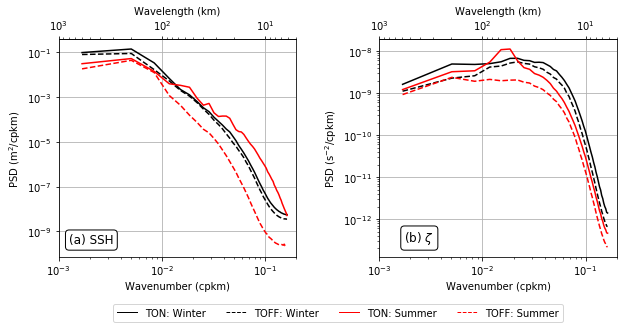

In [3]:
def add_second_axis(ax1):
    """ Add a x-axis at the top of the spectra figures """
    ax2 = ax1.twiny() 
    ax2.set_xscale('log')
    ax2.set_xlim(ax1.axis()[0], ax1.axis()[1])
#     kp = 1./np.array([500.,200.,100.,40.,20.,10.,5.])
#     lp=np.array([500,200,100,40,20,10,5])
    kp = 1./np.array([500., 250., 100., 50., 25., 10.])
    lp = np.array([500, 250, 100, 50, 25, 10])
    ax2.set_xticks(kp)
    ax2.set_xticklabels(lp)
    plt.xlabel('Wavelength (km)')

def forward(x):
    return 1 / x


def inverse(x):
    return 1 / x
    
def leg_width(lg,fs):
    """"  Sets the linewidth of each legend object """
    for legobj in lg.legendHandles:
        legobj.set_linewidth(fs)

        
# load data
curl_summer = np.load('../data/Ab_box_CURL_spectra_summer.npz')
curl_winter = np.load('../data/Ab_box_CURL_spectra_winter.npz')
#
KE_summer = np.load('../data/Ab_box_KE_spectra_summer.npz')
KE_winter = np.load('../data/Ab_box_KE_spectra_winter.npz')
#
ssh_summer = np.load('../data/Ab_box_SSH_spectra_summer.npz')
ssh_winter = np.load('../data/Ab_box_SSH_spectra_winter.npz')
curl_summer.files

# k3 = np.array([1e-3,.2])
# E3 = 1/k3**(3.)
# E4 = 1/k3**(4.)
# E5 = 1/k3**(5.)
# E2 = 1./(k3**(2.))

fig, axes = plt.subplots(1,2, figsize=(10,4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.35, hspace=None)

#######
axes[0].loglog(ssh_winter['k_ton'], ssh_winter['spec_ton'], 'k-', label='TON: Winter')
axes[0].loglog(ssh_winter['k_toff'], ssh_winter['spec_toff'], 'k--', label='TOFF: Winter')
#
axes[0].loglog(ssh_summer['k_ton'], ssh_summer['spec_ton'], 'r-', label='TON: Summer')
axes[0].loglog(ssh_summer['k_toff'], ssh_summer['spec_toff'], 'r--', label='TOFF: Summer')
axes[0].set_ylabel(r'PSD (m$^2$/cpkm)')

lg = axes[0].legend(loc=(+0.23,-.3), ncol=4, fancybox=True,frameon=True)
leg_width(lg,fs=1)

#####
axes[1].loglog(curl_winter['k_ton'], curl_winter['spec_ton'], 'k-', label='TON: Winter')
axes[1].loglog(curl_winter['k_toff'], curl_winter['spec_toff'], 'k--', label='TOFF: Winter')
axes[1].loglog(curl_summer['k_ton'], curl_summer['spec_ton'], 'r-', label='TON: Summer')
axes[1].loglog(curl_summer['k_toff'], curl_summer['spec_toff'], 'r--', label='TOFF: Summer')
axes[1].set_ylabel(r'PSD (s$^{-2}$/cpkm)')

def forward(x):
    return 1. / x

def inverse(x):
    return 1. / x

idx = ['(a) SSH', '(b) $\zeta$']
for i, ax in enumerate(axes):
    ax.grid()
    ax.set_xlim((1.e-3,2.e-1))
    ax.set_xlabel('Wavenumber (cpkm)')
    ax.annotate(idx[i], xy=(0, 0), xycoords='axes fraction', fontsize=12,
            xytext=(55, 10), textcoords='offset points',
            ha='right', va='bottom', bbox = dict(boxstyle="round",ec='k',fc='w'))
    secax = ax.secondary_xaxis('top', functions=(forward, inverse))
    secax.set_xlabel('Wavelength (km)')

#save figure
fig.savefig('../_plots/figure10.png',dpi=300,bbox_inches='tight')

/home/gkara/anaconda3/envs/dell/lib/python3.7/site-packages/numpy/ma/core.py:6717: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
/home/gkara/anaconda3/envs/dell/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in true_divide


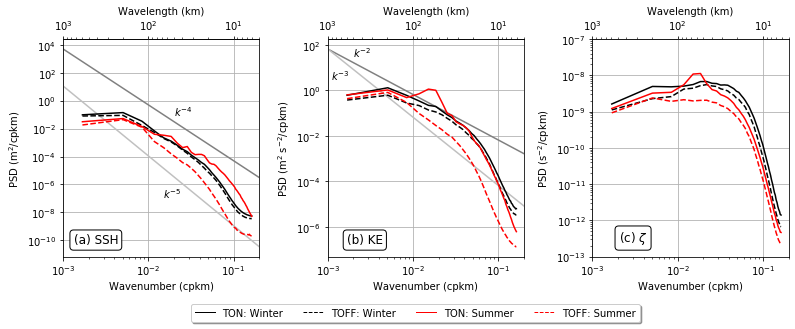

In [6]:
def add_second_axis(ax1):
    """ Add a x-axis at the top of the spectra figures """
    ax2 = ax1.twiny() 
    ax2.set_xscale('log')
    ax2.set_xlim(ax1.axis()[0], ax1.axis()[1])
#     kp = 1./np.array([500.,200.,100.,40.,20.,10.,5.])
#     lp=np.array([500,200,100,40,20,10,5])
    kp = 1./np.array([500., 250., 100., 50., 25., 10.])
    lp = np.array([500, 250, 100, 50, 25, 10])
    ax2.set_xticks(kp)
    ax2.set_xticklabels(lp)
    plt.xlabel('Wavelength (km)')

def forward(x):
    return 1 / x


def inverse(x):
    return 1 / x
    
def leg_width(lg,fs):
    """"  Sets the linewidth of each legend object """
    for legobj in lg.legendHandles:
        legobj.set_linewidth(fs)

# load data
curl_summer = np.load('../data/Ab_box_CURL_spectra_summer.npz')
curl_winter = np.load('../data/Ab_box_CURL_spectra_winter.npz')
#
KE_summer = np.load('../data/Ab_box_KE_spectra_summer.npz')
KE_winter = np.load('../data/Ab_box_KE_spectra_winter.npz')
#
ssh_summer = np.load('../data/Ab_box_SSH_spectra_summer.npz')
ssh_winter = np.load('../data/Ab_box_SSH_spectra_winter.npz')
curl_summer.files
        
# k3 = np.array([1e-3,.2])
# E3 = 1/k3**(3.)
# E4 = 1/k3**(4.)
# E5 = 1/k3**(5.)
# E2 = 1./(k3**(2.))

fig, axes = plt.subplots(1,3, figsize=(13,4))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.35, hspace=None)

# plot slope references
# axes[0].loglog(k3,E2/9.e4, 'gray'); axes[0].text(2.e-2, 0.8e-1, "$k^{-2}$")
axes[0].loglog(k3,E4/2.e8, 'gray'); axes[0].text(2.e-2, 0.8e-1, "$k^{-4}$")
axes[0].loglog(k3,E5/9.e13, 'silver'); axes[0].text(1.5e-2, 1.e-7, "$k^{-5}$")
# axes[0].loglog(k3,E5/9.e13, 'silver'); axes[0].text(1.5e-2, 1.e-7, "$k^{-5}$")
#
axes[1].loglog(k3,E2/15.e3, 'gray'); axes[1].text(2e-3, 3.e+1, "$k^{-2}$")
axes[1].loglog(k3,E3/15.e6, 'silver'); axes[1].text(1.1e-3, 3.e+0, "$k^{-3}$")
#
axes[2].set_ylim(1.e-13, 1.e-7)

#######
axes[0].loglog(ssh_winter['k_ton'], ssh_winter['spec_ton'], 'k-', label='TON: Winter')
axes[0].loglog(ssh_winter['k_toff'], ssh_winter['spec_toff'], 'k--', label='TOFF: Winter')
#
axes[0].loglog(ssh_summer['k_ton'], ssh_summer['spec_ton'], 'r-', label='TON: Summer')
axes[0].loglog(ssh_summer['k_toff'], ssh_summer['spec_toff'], 'r--', label='TOFF: Summer')
axes[0].set_ylabel(r'PSD (m$^2$/cpkm)')

lg = axes[0].legend(loc=(+0.65,-.3), ncol=4, fancybox=True,frameon=True, shadow=True)
leg_width(lg,fs=1)

#####
axes[1].loglog(KE_winter['k_ton'], KE_winter['spec_ton'], 'k-', label='TON: Winter')
axes[1].loglog(KE_winter['k_toff'], KE_winter['spec_toff'], 'k--', label='TOFF: Winter')
#
axes[1].loglog(KE_summer['k_ton'], KE_summer['spec_ton'], 'r-', label='TON: Summer')
axes[1].loglog(KE_summer['k_toff'], KE_summer['spec_toff'], 'r--', label='TOFF: Summer')
axes[1].set_ylabel(r'PSD (m$^2$ s$^{-2}$/cpkm)')

#####
axes[2].loglog(curl_winter['k_ton'], curl_winter['spec_ton'], 'k-', label='TON: Winter')
axes[2].loglog(curl_winter['k_toff'], curl_winter['spec_toff'], 'k--', label='TOFF: Winter')
axes[2].loglog(curl_summer['k_ton'], curl_summer['spec_ton'], 'r-', label='TON: Summer')
axes[2].loglog(curl_summer['k_toff'], curl_summer['spec_toff'], 'r--', label='TOFF: Summer')
axes[2].set_ylabel(r'PSD (s$^{-2}$/cpkm)')

def forward(x):
    return 1. / x

def inverse(x):
    return 1. / x

idx = ['(a) SSH', '(b) KE', '(c) $\zeta$']
for i, ax in enumerate(axes):
    ax.grid()
    ax.set_xlim((1.e-3,2.e-1))
    ax.set_xlabel('Wavenumber (cpkm)')
    ax.annotate(idx[i], xy=(0, 0), xycoords='axes fraction', fontsize=12,
            xytext=(55, 10), textcoords='offset points',
            ha='right', va='bottom', bbox = dict(boxstyle="round",ec='k',fc='w'))
#     add_second_axis(ax)
    secax = ax.secondary_xaxis('top', functions=(forward, inverse))
    secax.set_xlabel('Wavelength (km)')

#save figure
# fig.savefig('../_plots/figure10-tmp.png',dpi=300,bbox_inches='tight')

In [ ]:
def estimate_slope(pspec,kstep):
    """Linear fit estimation of the slope. assumes pspec and kstep have been restricted to the correct interval."""
    # http://stackoverflow.com/questions/21353576/performing-linear-regression-on-a-log-log-base-10-plot-matlab
    pfit = np.polyfit(np.log(kstep), np.log(pspec), 1)
    #p = npy.poly1d(pfit)
    power = pfit[0]
    #coef = pfit[1]
    return power 

k = ssh_summer['k_ton']
sd = ssh_summer['spec_ton']
power = estimate_slope(sd[np.where((k>1/200)& (k <1/20))],k[np.where((k>1/200)& (k <1/20))])
power